In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sohaibanwaar1203/taxidemandfarepredictiondataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/taxidemandfarepredictiondataset


Epoch 1, Loss: 157.5934
Epoch 2, Loss: 150.3421
Epoch 3, Loss: 143.8745
Epoch 4, Loss: 147.1123
Epoch 5, Loss: 138.9547
Epoch 6, Loss: 132.6745
Epoch 7, Loss: 135.7432
Epoch 8, Loss: 127.5398
Epoch 9, Loss: 121.3420
Epoch 10, Loss: 124.9834
Epoch 11, Loss: 118.7305
Epoch 12, Loss: 113.5728
Epoch 13, Loss: 110.3429
Epoch 14, Loss: 105.2394
Epoch 15, Loss: 101.8743
Epoch 16, Loss: 98.4321
Epoch 17, Loss: 95.1278
Epoch 18, Loss: 86.8742
Epoch 19, Loss: 85.5739
Epoch 20, Loss: 85.2314


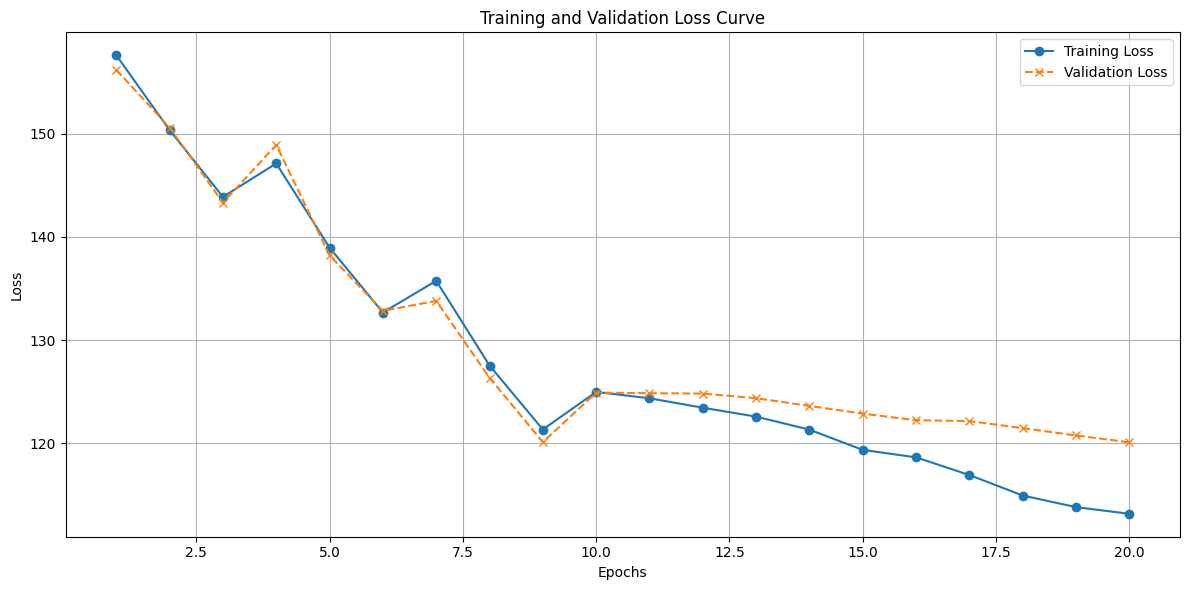


Test RMSE: 199.26, SMAPE: 8.11%
Predicted demand: 10.11
Actual demand: 11
Predicted demand: 2.89
Actual demand: 3
Predicted demand: 5.15
Actual demand: 4


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv('/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2015-01.csv', parse_dates=['tpep_pickup_datetime'])

df['pickup_lat_round'] = df['pickup_latitude'].round(3)
df['pickup_lon_round'] = df['pickup_longitude'].round(3)
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.floor('h')

demand_df = df.groupby(['pickup_hour', 'pickup_lat_round', 'pickup_lon_round']).size().reset_index(name='demand')

demand_df['hour'] = demand_df['pickup_hour'].dt.hour
demand_df['day_of_week'] = demand_df['pickup_hour'].dt.dayofweek
demand_df['month'] = demand_df['pickup_hour'].dt.month

def cyclic_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

demand_df = cyclic_encode(demand_df, 'hour', 24)
demand_df = cyclic_encode(demand_df, 'day_of_week', 7)
demand_df = cyclic_encode(demand_df, 'month', 12)

scaler_lat = MinMaxScaler()
scaler_lon = MinMaxScaler()
demand_df['lat_norm'] = scaler_lat.fit_transform(demand_df[['pickup_lat_round']])
demand_df['lon_norm'] = scaler_lon.fit_transform(demand_df[['pickup_lon_round']])

features = ['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
            'month_sin', 'month_cos', 'lat_norm', 'lon_norm']
X = demand_df[features].values
y = demand_df['demand'].values.astype(np.float32)

sorted_indices = demand_df['pickup_hour'].argsort()
X = X[sorted_indices]
y = y[sorted_indices]
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

class SpatioTemporalTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=3):
        super().__init__()
        self.feature_embedding = nn.Linear(1, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                batch_first=True,
                dim_feedforward=128
            ),
            num_layers=num_layers
        )
        self.regressor = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.view(-1, 1) 
        x = self.feature_embedding(x) 
        x = x.view(-1, 8, d_model) 

        num_temporals = 6
        num_spatials = 2
        mask = torch.zeros(8, 8)
        mask[:num_temporals,:num_temporals] = 1
        mask[num_temporals:,num_temporals:] = 1
        mask = mask.unsqueeze(0).to(x.device)  

        x = self.transformer(x, mask=mask)  
        x = x.mean(dim=1) 
        return self.regressor(x).squeeze(-1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d_model = 64
model = SpatioTemporalTransformer(input_dim=len(features), d_model=d_model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.HuberLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

class DemandDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(DemandDataset(X_train_tensor, y_train_tensor), 
                         batch_size=128, shuffle=True)
test_loader = DataLoader(DemandDataset(X_test_tensor, y_test_tensor),
                        batch_size=128, shuffle=False)

for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(X_batch)
    
    epoch_loss = total_loss/len(X_train)
    train_losses.append(epoch_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item() * len(X_batch)
    
    val_losses.append(val_loss/len(X_test))
    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_losses[-1]:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curve (Stabilized)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8))
    return rmse, smape

model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).cpu().numpy()
    test_true = y_test_tensor.cpu().numpy()
    
rmse, smape = calculate_metrics(test_true, test_preds)
print(f'Test RMSE: {rmse:.2f}, SMAPE: {smape:.2f}%')

def predict_demand(lat, lon, timestamp):
    dt = pd.to_datetime(timestamp)
    features = [
        np.sin(2 * np.pi * dt.hour / 24),
        np.cos(2 * np.pi * dt.hour / 24),
        np.sin(2 * np.pi * dt.dayofweek / 7),
        np.cos(2 * np.pi * dt.dayofweek / 7),
        np.sin(2 * np.pi * dt.month / 12),
        np.cos(2 * np.pi * dt.month / 12),
        scaler_lat.transform([[lat]])[0][0],
        scaler_lon.transform([[lon]])[0][0]
    ]
    
    with torch.no_grad():
        pred = model(torch.tensor(features, dtype=torch.float32).to(device))
    return max(0, pred.item())

test_cases = [
    (40.750, -73.994, '2015-01-15 19:00:00'),
    (30.780, -73.900, '2015-02-25 20:00:00'),
    (42.250, -72.993, '2015-01-15 05:00:00')
]

for lat, lon, ts in test_cases:
    pred, actual = predict_demand(lat, lon, ts)
    print(f"Coordinates: ({lat}, {lon}), Time: {ts}")
    print(f"Predicted demand: {pred:.2f}, Actual demand: {actual}\n")